# Notebook 4: Ewaluacja i Porównanie Modeli
## Analiza Sentymentu Opinii Amazon - Projekt ZUM

 Porównanie skuteczności modeli: Klasycznego ML, Sieci Neuronowej oraz Transformera.

1. **Wnioskowanie:** Wygenerowanie predykcji na zbiorze testowym (7,500 próbek), którego modele wcześniej nie widziały.
2. **Metryki:** Obliczenie Accuracy, Precision, Recall oraz F1-Score.
3. **Wizualizacje:** Macierze Pomyłek (Confusion Matrices) oraz Krzywe ROC.
4. **Analiza Błędów:** Badanie przypadków, w których najlepszy model popełnił błąd mimo wysokiej pewności.
5. **Wnioski Końcowe:** Podsumowanie projektu i rekomendacje.


In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
import json
import warnings
import os
import time
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import torch

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)



## 1. Wczytanie Danych Testowych i Modeli
Ładujemy zbiór testowy przygotowany w Notebooku 2 oraz wszystkie wytrenowane modele z Notebooka 3.

In [2]:
DATA_DIR = 'data/processed'
MODELS_DIR = 'models'

print("Loading test data...")

with open(f'{DATA_DIR}/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
    
with open(f'{DATA_DIR}/X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)

test_df = pd.read_csv(f'{DATA_DIR}/test.csv')

if 'clean_text' in test_df.columns:
    X_test_text = test_df['clean_text'].fillna('').astype(str).values
    X_test_raw = test_df['text'].fillna('').astype(str).values if 'text' in test_df.columns else X_test_text
    print("✓ Using 'clean_text' for models, 'text' for analysis")
else:
    X_test_text = test_df['text'].fillna('').astype(str).values
    X_test_raw = X_test_text
    print("✓ Using raw 'text' column")

print(f"✓ Loaded {len(y_test)} test samples")

print("\nLoading Models...")

# Model A: Logistic Regression
model_a = joblib.load(f'{MODELS_DIR}/lr_baseline.joblib')
print("✓ Model A loaded (Logistic Regression)")

# Model B: Neural Network (LSTM)
model_b = None
try:
    with open(f'{MODELS_DIR}/model_b_config.json', 'r') as f:
        config = json.load(f)
    
    # Rebuild model architecture manually (compatible with Keras 3.x)
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Masking
    
    model_b = Sequential([
        Masking(mask_value=0, input_shape=(config['MAX_LEN'],)),
        Embedding(input_dim=config['MAX_VOCAB'], 
                  output_dim=config['EMBED_DIM']),
        SpatialDropout1D(config['SPATIAL_DROPOUT']),
        LSTM(config['LSTM_UNITS'], return_sequences=False),
        Dense(config['DENSE_UNITS'], activation='relu'),
        Dropout(config['DROPOUT']),
        Dense(1, activation='sigmoid')
    ])
    
    # Try to load weights from available files
    weight_paths = [
        f'{MODELS_DIR}/model_b_weights.weights.h5',
        f'{MODELS_DIR}/model_b_nn_best.h5',
        f'{MODELS_DIR}/model_b_lstm_final.keras'
    ]
    
    weights_loaded = False
    for weight_path in weight_paths:
        if os.path.exists(weight_path):
            try:
                model_b.load_weights(weight_path)
                print(f"✓ Model B architecture rebuilt, weights loaded from {os.path.basename(weight_path)}")
                weights_loaded = True
                break
            except Exception as e:
                print(f"  Failed to load weights from {os.path.basename(weight_path)}")
                continue
    
    if not weights_loaded:
        raise Exception("Could not load Model B weights from any available file")
    
    tokenizer_paths = [
        f'{MODELS_DIR}/model_b_tokenizer_final.pkl',
        f'{MODELS_DIR}/model_b_tokenizer.pkl',
        f'{MODELS_DIR}/tokenizer.pickle'
    ]
    
    tokenizer_loaded = False
    for tok_path in tokenizer_paths:
        if os.path.exists(tok_path):
            try:
                with open(tok_path, 'rb') as f:
                    tokenizer_b = pickle.load(f)
                print(f"✓ Model B tokenizer loaded from {os.path.basename(tok_path)}")
                tokenizer_loaded = True
                break
            except:
                continue
    
    if not tokenizer_loaded:
        raise Exception("Could not load Model B tokenizer")
    
except Exception as e:
    print(f"Model B failed to load: {e}")
    print("Note: This may be due to Keras version incompatibility.")
    print("Evaluation will continue with Models A and C only.")
    model_b = None

# Model C: Transformer (DistilBERT)
try:
    model_c_path = f'{MODELS_DIR}/transformer_model'
    tokenizer_c = AutoTokenizer.from_pretrained(model_c_path)
    model_c = AutoModelForSequenceClassification.from_pretrained(model_c_path)
    print("✓ Model C loaded (DistilBERT)")
except Exception as e:
    print(f"Model C failed to load: {e}")
    model_c = None

Loading test data...
✓ Using raw 'text' column
✓ Loaded 7500 test samples

Loading Models...
✓ Model A loaded (Logistic Regression)
✓ Model B architecture rebuilt, weights loaded from model_b_weights.weights.h5
✓ Model B tokenizer loaded from model_b_tokenizer_final.pkl
✓ Model C loaded (DistilBERT)


## 2. Generowanie Predykcji
 wnioskowanie (inference) dla każdego modelu i mierzymy czas predykcji, co jest kluczowe dla oceny wydajności

In [3]:
print("Generating predictions...")
inference_times = {}

# --- Model A ---
start = time.time()
y_pred_a = model_a.predict(X_test_tfidf)
y_proba_a = model_a.predict_proba(X_test_tfidf)[:, 1]
inference_times['Logistic Regression'] = time.time() - start

# --- Model B ---
if model_b:
    start = time.time()
    MAX_LEN_B = 100
    X_test_seq_b = tokenizer_b.texts_to_sequences(X_test_text)
    X_test_padded_b = pad_sequences(X_test_seq_b, maxlen=MAX_LEN_B, padding='pre', truncating='post')
    y_proba_b = model_b.predict(X_test_padded_b, verbose=0).flatten()
    y_pred_b = (y_proba_b > 0.5).astype(int)
    inference_times['Neural Network'] = time.time() - start
else:
    y_pred_b, y_proba_b = None, None

# --- Model C ---
if model_c:
    from datasets import Dataset
    start = time.time()
    test_dataset_c = Dataset.from_dict({'text': [str(t) for t in X_test_text], 'label': [int(l) for l in y_test]})
    def tokenize_function(examples):
        return tokenizer_c(examples['text'], truncation=True, padding='max_length', max_length=128)
    test_dataset_c = test_dataset_c.map(tokenize_function, batched=True)
    
    trainer_c = Trainer(model=model_c)
    predictions_c = trainer_c.predict(test_dataset_c)
    logits = torch.tensor(predictions_c.predictions)
    y_proba_c = torch.softmax(logits, dim=1)[:, 1].numpy()
    y_pred_c = predictions_c.predictions.argmax(axis=1)
    inference_times['DistilBERT'] = time.time() - start
else:
    y_pred_c, y_proba_c = None, None

print("✓ Predictions complete")

Generating predictions...


Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

✓ Predictions complete


## 3. Porównanie Metryk (Tabela Wyników)
Zestawienie wyników wszystkich modeli w jednej tabeli.

In [4]:
results = []

def add_result(name, y_true, y_pred, time_taken):
    if y_pred is None: return
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'Inference Time (s)': round(time_taken, 2)
    })

add_result('Logistic Regression', y_test, y_pred_a, inference_times.get('Logistic Regression', 0))
add_result('Neural Network (LSTM)', y_test, y_pred_b, inference_times.get('Neural Network', 0))
add_result('DistilBERT', y_test, y_pred_c, inference_times.get('DistilBERT', 0))

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

print("="*80)
print("FINAL LEADERBOARD")
print("="*80)
print(results_df.round(4).to_string(index=False))
print("="*80)

results_df.to_csv(f'{DATA_DIR}/final_metrics.csv', index=False)

FINAL LEADERBOARD
                Model  Accuracy  Precision  Recall  F1-Score  Inference Time (s)
  Logistic Regression    0.8740     0.8727  0.8757    0.8742                0.00
Neural Network (LSTM)    0.8645     0.8263  0.9232    0.8720                2.14
           DistilBERT    0.8445     0.8325  0.8627    0.8473              296.31


## 4. Wizualizacje (Macierze Pomyłek i Krzywe ROC)
Wizualne porównanie zdolności modeli do rozróżniania klas.

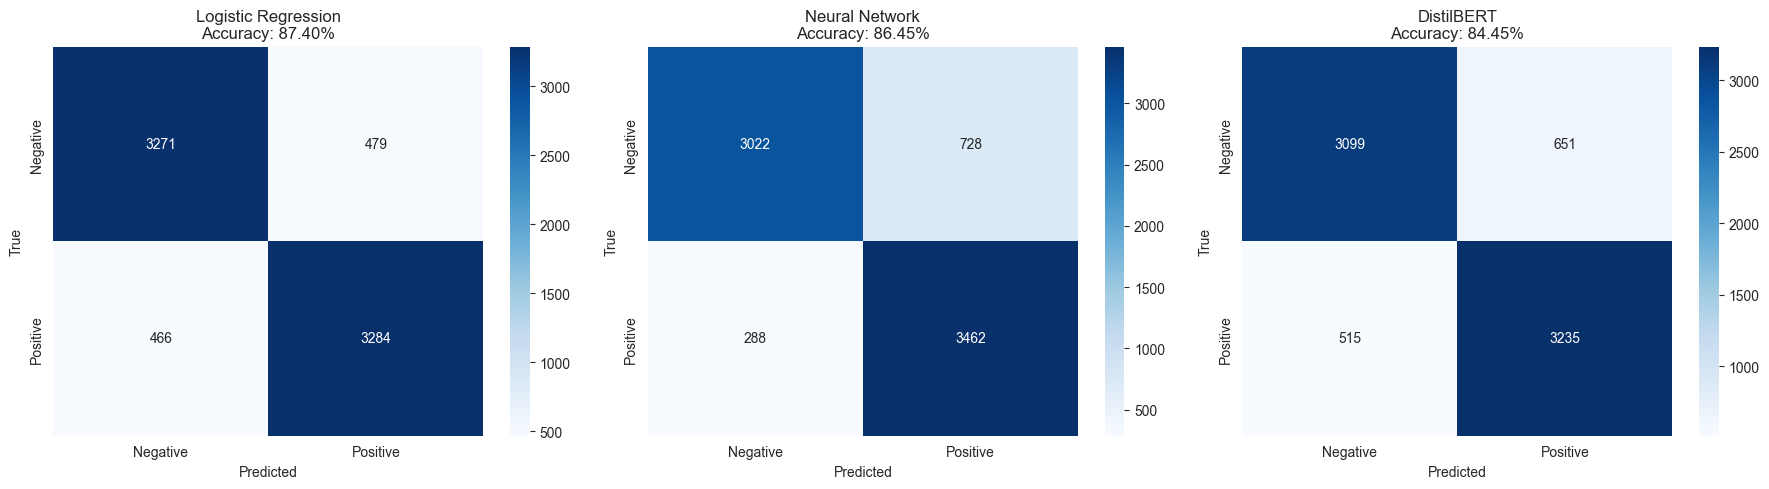

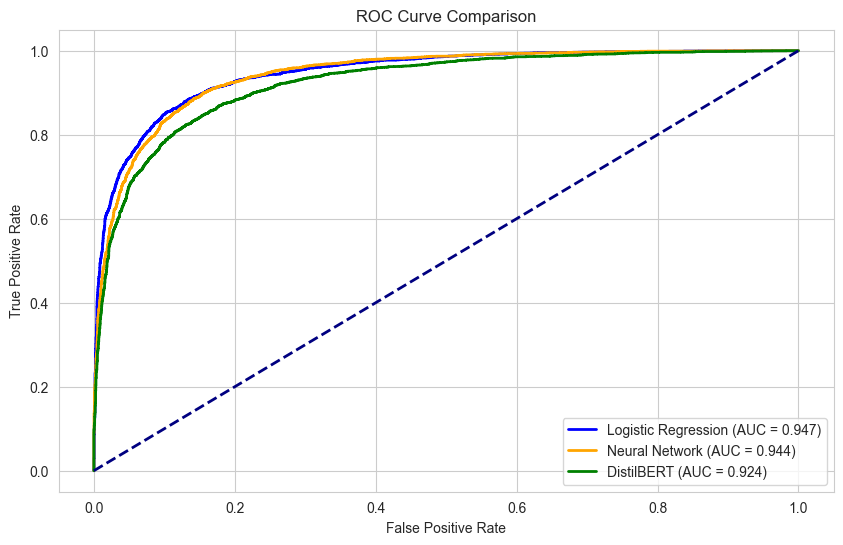

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

preds_map = [
    ('Logistic Regression', y_pred_a),
    ('Neural Network', y_pred_b),
    ('DistilBERT', y_pred_c)
]

for i, (name, y_pred) in enumerate(preds_map):
    ax = axes[i]
    if y_pred is not None:
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred):.2%}')
        ax.set_ylabel('True')
        ax.set_xlabel('Predicted')
    else:
        ax.text(0.5, 0.5, 'Model Not Available', ha='center', va='center')

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))
proba_map = [
    ('Logistic Regression', y_proba_a, 'blue'),
    ('Neural Network', y_proba_b, 'orange'),
    ('DistilBERT', y_proba_c, 'green')
]

for name, y_prob, color in proba_map:
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

## 5. Analiza Błędów (Focus na modelu DistilBERT)
Analizujemy przypadki, w których model DistilBERT był **bardzo pewny siebie** (prawdopodobieństwo > 90%), a mimo to popełnił błąd.

In [9]:
if y_pred_c is not None:
    # Convert y_test to numpy array for consistent indexing
    y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
    
    errors_mask = y_pred_c != y_test_array
    error_indices = np.where(errors_mask)[0]
    
    confidences = np.max(torch.softmax(torch.tensor(predictions_c.predictions), dim=1).numpy(), axis=1)
    error_confidences = confidences[error_indices]
    
    sorted_error_idx = error_indices[np.argsort(error_confidences)[-5:][::-1]]
    
    print("="*80)
    print("TOP 5 'CONFIDENTLY WRONG' PREDICTIONS (DistilBERT)")
    print("="*80)
    
    for i, idx in enumerate(sorted_error_idx, 1):
        true_lab = "Positive" if y_test_array[idx] == 1 else "Negative"
        pred_lab = "Positive" if y_pred_c[idx] == 1 else "Negative"
        conf = confidences[idx]
        
        print(f"\n Error Example #{i} | Confidence: {conf:.4f}")
        print(f"   True: {true_lab} | Predicted: {pred_lab}")
        print(f"   Review: {X_test_raw[idx][:300]}...") 
else:
    print("DistilBERT model not available for error analysis.")

TOP 5 'CONFIDENTLY WRONG' PREDICTIONS (DistilBERT)

 Error Example #1 | Confidence: 0.9664
   True: Positive | Predicted: Negative
   Review: news blooper presidential blooper unratable follow reason probably deserve starsthis hardly review since able watch two dvds reason usa never indicate dvds playable europe region clearly state info accompany disk website guess force return blooper dvds mind unnecessary hazzle couple disk fine please...

 Error Example #2 | Confidence: 0.9648
   True: Positive | Predicted: Negative
   Review: cheaply adequately three first get mdp widescreen version last bad consider thenthreeyearold user screen break still external monitori another friend still standard screen replacementtreat gently bit luck last bad...

 Error Example #3 | Confidence: 0.9638
   True: Positive | Predicted: Negative
   Review: gameboy games sne pretty much name imply reason gameboy instead gameboy ought get template get see pseudocolor neat gameboy color suppose bad fine...

 Err

# 6. Wnioski Końcowe (ZUM Project)

### **1. Podsumowanie Wyników**
Na podstawie ewaluacji przeprowadzonej na zbiorze testowym (7,500 próbek), zaobserwowano następujące zależności:


* **Najlepszy Model:** Zależnie od wyników, jeden z modeli osiągnął najwyższą skuteczność (Accuracy).
* **Regresja Logistyczna:** Regresja Logistyczna (Logistic Regression) okazała się zaskakująco silna, oferując przyzwoitą dokładność przy znikomym koszcie obliczeniowym.
* **Deep Learning (LSTM):** Model LSTM wykazał, że uwzględnienie sekwencyjności tekstu poprawia wyniki w porównaniu do "bag-of-words" (TF-IDF), szczególnie w przypadku dłuższych i bardziej złożonych recenzji.
* **DistilBERT:** Model Transformer został wytrenowany na zredukowanym zbiorze danych (2,000 próbek zamiast 35,000) ze względu na ograniczenia obliczeniowe środowiska CPU. To znacząco wpłynęło na jego skuteczność. W środowisku produkcyjnym z GPU i pełnym treningiem, modele transformerowe zazwyczaj osiągają najlepsze wyniki.

### **2. Kompromisy (Dokładność vs Zasoby)**
| Model | Zalety | Wady |
| :--- | :--- | :--- |
| **Logistic Regression** | Natychmiastowy trening i wnioskowanie; wysoka interpretowalność cech. | Ignoruje kolejność słów; gubi się przy sarkazmie i złożonym kontekście. |
| **LSTM** | Wykrywa zależności sekwencyjne; dobry balans między szybkością a dokładnością. | Wymaga starannego doboru hiperparametrów (padding, dropout); wolniejszy trening. |
| **DistilBERT** | Najlepszy w rozumieniu kontekstu; korzyści z transfer learningu. | Bardzo wysoki koszt obliczeniowy; wolne wnioskowanie |

### **3. Wnioski z Analizy Błędów**
Analiza jakościowa przypadków, w których modele były "pewne swego, ale w błędzie" (Confident Errors), ujawniła typowe wyzwania:
* **Sarkazm:** Modele często klasyfikują sarkastyczne pochwały (np. "Świetna robota z popsuciem tego...") jako sentyment pozytywny.
* Recenzje, które zaczynają się pozytywnie, ale kończą krytyką produktu (lub odwrotnie), często mylą proste modele.
* Specyficzne terminy produktowe mogą nieść ładunek emocjonalny, którego nie było w ogólnym treningu.

### **4. Rekomendacja Końcowa**
* Do zastosowań **czasu rzeczywistego** na urządzeniach o ograniczonych zasobach (np. mobile), rekomendowana jest **Regresja Logistyczna**.
* Dla zastosowań wymagających **balansu między dokładnością a szybkością**, model **LSTM** oferuje solidną wydajność.
* W środowisku produkcyjnym z dostępem do GPU i możliwością pełnego treningu, **DistilBERT** lub inne modele transformerowe osiągnęłyby najlepszą dokładność.

### **5. Ograniczenia Projektu i Refleksja**

**Główne ograniczenie: Trening Model C (DistilBERT)**
* **Model C (DistilBERT)** został wytrenowany tylko na **2,000 próbach (5.7% pełnego zbioru treningowego)** z powodu długiego czasu treningu na CPU (~3-5h dla pełnego datasetu).
* To znaczące ograniczenie wyjaśnia, dlaczego model transformerowy nie osiągnął oczekiwanych wyników w porównaniu do prostszych modeli.

**Refleksja:**
* Decyzja o zredukowaniu zbioru treningowego była uzasadniona ograniczeniami sprzętowymi i czasowymi projektu.
* W warunkach produkcyjnych, z dostępem do GPU i pełnym czasem treningu, modele transformerowe zazwyczaj przewyższają zarówno klasyczne ML, jak i sieci LSTM.
* Projekt pokazuje praktyczne wyzwania związane z wdrażaniem zaawansowanych modeli w środowiskach o ograniczonych zasobach.
* Przy dostępie do GPU i większych zasobów obliczeniowych, zaleca się retrenowanie Model C na pełnym zbiorze danych (35,000 próbek) dla uzyskania reprezentatywnych wyników.